Call Data

In [49]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:]
                       for line in f], dtype=float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1]
                       for line in f], dtype=float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:]
                      for line in f], dtype=float)



In [50]:
X_train

array([[33.,  1.,  0., ..., 52.,  0.,  1.],
       [63.,  1.,  0., ..., 52.,  0.,  1.],
       [71.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [16.,  0.,  0., ...,  8.,  1.,  0.],
       [48.,  1.,  0., ..., 52.,  0.,  1.],
       [48.,  0.,  0., ...,  0.,  0.,  1.]])

In [51]:
X_train.shape

(54256, 510)

In [52]:
import pandas as pd
import numpy as np

# Define the normalization function


def _normalize(X, train=True, specified_column=None, X_mean=None, X_std=None):
    if specified_column is None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column], axis=0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], axis=0).reshape(1, -1)
    X[:, specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    return X, X_mean, X_std

# Define the train-dev split function


def _train_dev_split(X, Y, dev_ratio=0.1):
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]


# Assuming X_train and X_test are already defined
# Elevate the first feature to the power of 10 for both training and testing data
X_train_df = pd.DataFrame(X_train)
# Adjusted to use DataFrame column indexing
first_feature = X_train_df.columns[0]
X_train_df[first_feature] = X_train_df[first_feature] ** 10

X_test_df = pd.DataFrame(X_test)
X_test_df[first_feature] = X_test_df[first_feature] ** 10

# Normalize the training and testing data
X_train_normalized, X_mean, X_std = _normalize(X_train_df.values, train=True)
X_test_normalized, _, _ = _normalize(
    X_test_df.values, train=False, X_mean=X_mean, X_std=X_std)

# Split the training data into training set and development set
X_train_selected, Y_train, X_dev_selected, Y_dev = _train_dev_split(
    X_train_normalized, Y_train, dev_ratio=0.1)

# Calculate the sizes and dimensions of the datasets
train_size = X_train_selected.shape[0]
dev_size = X_dev_selected.shape[0]
test_size = X_test_normalized.shape[0]
data_dim = X_train_selected.shape[1]

# Print the details
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


In [53]:
X_train_selected

array([[-0.26405589,  0.99959458, -0.1822401 , ...,  0.80645987,
        -1.01485522,  1.01485522],
       [ 0.01165765,  0.99959458, -0.1822401 , ...,  0.80645987,
        -1.01485522,  1.01485522],
       [ 0.64818085, -1.00040555, -0.1822401 , ..., -1.45536172,
        -1.01485522,  1.01485522],
       ...,
       [-0.21545244, -1.00040555, -0.1822401 , ...,  0.80645987,
        -1.01485522,  1.01485522],
       [-0.25259188,  0.99959458, -0.1822401 , ...,  0.28450104,
        -1.01485522,  1.01485522],
       [-0.25686003, -1.00040555, -0.1822401 , ...,  0.80645987,
         0.98536219, -0.98536219]])

Functions

In [54]:
def _shuffle(X, Y):  # 打亂兩個長度相等的列表或數組 X 和 Y
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)  # 將這個序列隨機打亂
    return (X[randomize], Y[randomize])


def _sigmoid(z):  # 計算 Sigmoid 函數的值，常用於將邏輯回歸的輸出轉化為概率
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))


def _f(X, w, b):  # 實現邏輯回歸模型函數，用於計算給定輸入 X 下，每個樣本被正標籤預測的概率
    return _sigmoid(np.matmul(X, w) + b)  # 得到邏輯回歸的線性輸出，然後通過 Sigmoid 函數轉化為概率


def _predict(X, w, b):  # 基於邏輯回歸模型的輸出，為每個輸入 X 的行生成一個預測（0 或 1）
    # 將函數的輸出結果四捨五入（np.round），將概率轉化為 0 或 1 的預測，然後轉換為整數
    return np.round(_f(X, w, b)).astype(int)


def _accuracy(Y_pred, Y_label):  # 計算預測準確率
    # 計算預測值 Y_pred 和實際標籤 Y_label 之間的平均絕對差異，然後用 1 減去這個值來得到準確率。
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

def _normalize(X, train=True, specified_column=None, X_mean=None, X_std=None):

    if specified_column == None:  # 如果沒有指定 specified_column，則對 X 中的所有列進行正規化
        specified_column = np.arange(X.shape[1])
    # 如果是訓練階段（train=True），則計算指定列的平均值 (X_mean) 和標準差 (X_std)
    if train:
        X_mean = np.mean(X[:, specified_column], 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], 0).reshape(1, -1)

    # 使用計算出的平均值和標準差來正規化指定的列，這裡的 1e-8 是為了避免除以零的情況
    X[:, specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    # 函數返回正規化後的 X，以及用於正規化的 X_mean 和 X_std
    return X, X_mean, X_std


def _train_dev_split(X, Y, dev_ratio):
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# 計算交叉熵損失，這是一種衡量模型預測概率與實際標籤之間差異的方法，常用於分類問題。


def _cross_entropy_loss(y_pred, Y_label):
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - \
        np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

# 計算交叉熵損失對權重 w 和偏差 b 的梯度。這些梯度用於更新模型的權重和偏差，以最小化損失函數。

def _gradient(X, Y_label, w, b):
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

Regularization & Split Dataset

In [55]:
X_train_df.shape

(54256, 510)

In [56]:
# 初始化權重 w 和偏差 b。這是訓練開始前的準備步驟。
w = np.random.randn(data_dim) * 0.01  # 小的隨機數初始化
b = np.zeros((1,))

# 訓練參數設置
max_iter = 50  # 增加迭代次數
batch_size = 16  # 調整批量大小
learning_rate = 0.1  # 調整學習率
learning_rate_decay = 0.95  # 學習率衰減

# 損失和準確率紀錄
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

step = 1

# 迭代訓練: 對於特定的迭代次數進行操作
for epoch in range(max_iter):
    if epoch % 10 == 0 and epoch > 0:
        learning_rate *= learning_rate_decay

    # 使用選定特徵的訓練集進行隨機打亂
    X_train_shuffled, Y_train_shuffled = _shuffle(X_train_selected, Y_train)

    for idx in range(int(np.floor(train_size / batch_size))):
        X_batch = X_train_shuffled[idx*batch_size:(idx+1)*batch_size]
        Y_batch = Y_train_shuffled[idx*batch_size:(idx+1)*batch_size]

        w_grad, b_grad = _gradient(X_batch, Y_batch, w, b)

        w = w - learning_rate / np.sqrt(step) * w_grad
        b = b - learning_rate / np.sqrt(step) * b_grad

        step += 1

    # 計算訓練集和開發集的預測、準確率和損失
    y_train_pred = _f(X_train_selected, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev_selected, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

# 輸出最終的訓練和開發集損失及準確率
print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.2674092238920191
Development loss: 0.2908138208272099
Training accuracy: 0.8848249027237354
Development accuracy: 0.8739402875046074


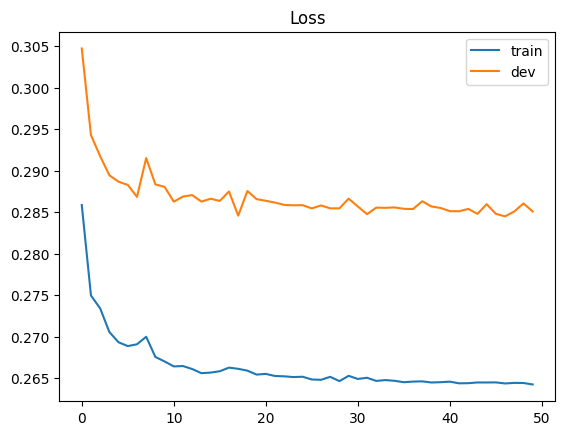

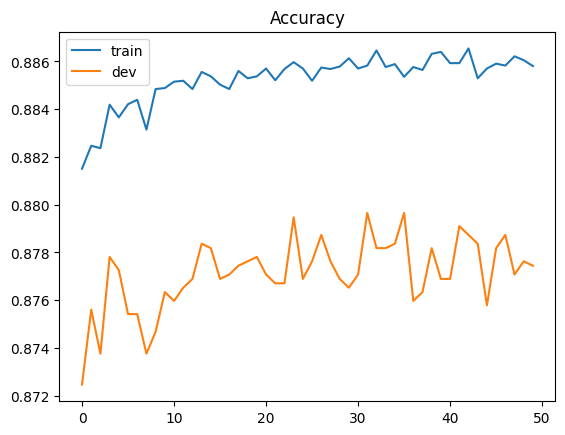

In [9]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

In [10]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Unemployed full-time 1.1189806886969682
 California -0.8152179778840035
 1 0.8005249906057196
 Other Rel 18+ ever marr RP of subfamily -0.6662270498433075
capital losses 0.6582447264152376
id 0.5708403232326507
dividends from stocks -0.4691365459239124
 Not in universe -0.4308974403630985
 Italy -0.42717429051015543
 2 -0.3936395372287497


In [11]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:]
                       for line in f], dtype=float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1]
                       for line in f], dtype=float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:]
                      for line in f], dtype=float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train=True)
X_test, _, _ = _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [12]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis=0)
mean_1 = np.mean(X_train_1, axis=0)

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]),
                    [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]),
                    [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]
       ) / (X_train_0.shape[0] + X_train_1.shape[0])

In [13]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b = (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0])

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8690098790917133


In [14]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 6.53173828125
 41 5.7802734375
 Agriculture -5.7724609375
 29 -5.642578125
 Other professional services -5.642578125
 44 5.6416015625
 Forestry and fisheries 5.388671875
 West 5.2906494140625
 Abroad -5.064453125
 34 -4.98046875


: 